In [1]:
import tensorflow as tf
import numpy as np
import os
import zipfile

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from cv2 import resize

from os import path, listdir


from matplotlib import pyplot as plt

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0


In [2]:
train_url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip'
test_url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip'
valid_url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip'

train_path = tf.keras.utils.get_file('train.zip', origin=train_url)
test_path = tf.keras.utils.get_file('test.zip', origin=test_url)
valid_path = tf.keras.utils.get_file('valid.zip', origin=valid_url)

data_dir = 'data'

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

if len(os.listdir(train_dir)) == 0:
  with zipfile.ZipFile(train_path, 'r') as zipFile:
    zipFile.extractall(data_dir)

if len(os.listdir(test_dir)) == 0:
  with zipfile.ZipFile(test_path, 'r') as zipFile:
    zipFile.extractall(data_dir)

if len(os.listdir(valid_dir)) == 0:
  with zipfile.ZipFile(valid_path, 'r') as zipFile:
    zipFile.extractall(data_dir)

864542720/864538487 [==============================] - 39s 0us/step


In [3]:
batch_size = 32
epochs = 15

In [4]:
#data generator class; yields batches of data for training/testing
class ImageGenerator():

    def __init__(self, directory, batch_size=16, shuffle=False, max_dimension=None):        
        
        self.directories = directory
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.max_dimension = max_dimension
        
        self.image_paths = []
        self.class_labels = []
        
        #create list of image file paths and class target labels
        for class_label, class_dir in enumerate(listdir(directory)):
            self.image_paths += [path.join(directory,class_dir,f) for f in listdir(path.join(directory,class_dir))]
            self.class_labels += [class_label for _ in listdir(path.join(directory,class_dir))]

        self.image_paths = np.array(self.image_paths)
        self.class_labels = np.array(self.class_labels)

        #index array for shuffling data
        self.idx = np.arange(len(self.image_paths))
        
    
    def __len__(self):
        
        #number of batches in an epoch
        return int(np.ceil(len(self.image_paths)/float(self.batch_size)))
    
    
    def _load_image(self,img_path):
        
        #load image from path and convert to array
        img = load_img(img_path, color_mode='rgb', interpolation='nearest')
        img = img_to_array(img)
        
        #downsample image if above allowed size if specified
        max_dim = max(img.shape) 
        if self.max_dimension:
            if max_dim > self.max_dimension:
                new_dim = tuple(d*self.max_dimension//max_dim for d in img.shape[1::-1])
                img = resize(img, new_dim)
            
        #scale image values
        img = preprocess_input(img)

        return img
    
    
    def _pad_images(self,img,shape):
        #pad images to match largest image in batch
        img = np.pad(img,(*[((shape[i]-img.shape[i])//2,
                    ((shape[i]-img.shape[i])//2) + ((shape[i]-img.shape[i])%2)) for i in range(2)],
                          (0,0)),mode='constant',constant_values=0.)
        
        return img


    def __call__(self):
        #shuffle index
        if self.shuffle:
            np.random.shuffle(self.idx)
        
        #generate batches
        for batch in range(len(self)):

            batch_image_paths = self.image_paths[self.idx[batch*self.batch_size:(batch+1)*self.batch_size]]
            batch_class_labels = self.class_labels[self.idx[batch*self.batch_size:(batch+1)*self.batch_size]]

            batch_images = [self._load_image(image_path) for image_path in batch_image_paths]

            max_resolution = tuple(max([img.shape[i] for img in batch_images]) for i in range(2))
            batch_images = np.array([self._pad_images(image,max_resolution) for image in batch_images])

            yield batch_images, batch_class_labels

In [16]:
train_image_generator = ImageGenerator(train_dir,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       max_dimension = 1024)

test_image_generator = ImageGenerator(test_dir,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       max_dimension = 1024)

validation_data_generator = ImageGenerator(valid_dir,
                                           batch_size=batch_size,
                                           max_dimension = 1024)

train_dataset = tf.data.Dataset.from_generator(train_image_generator, 
                                               (tf.float32, tf.int32), 
                                               (tf.TensorShape([None,None,None,3]), tf.TensorShape([None])))
train_dataset = train_dataset.repeat()

test_dataset = tf.data.Dataset.from_generator(test_image_generator, 
                                              (tf.float32, tf.int32),
                                              (tf.TensorShape([None,None,None,3]), tf.TensorShape([None])))
test_dataset = test_dataset.repeat()

validation_dataset = tf.data.Dataset.from_generator(validation_data_generator, 
                                                    (tf.float32, tf.int32),
                                                    (tf.TensorShape([None,None,None,3]), tf.TensorShape([None])))
validation_dataset = validation_dataset.repeat()

In [17]:
iter = train_dataset.take(5).as_numpy_iterator()

sample_training_images, labels = next(iter)

In [18]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


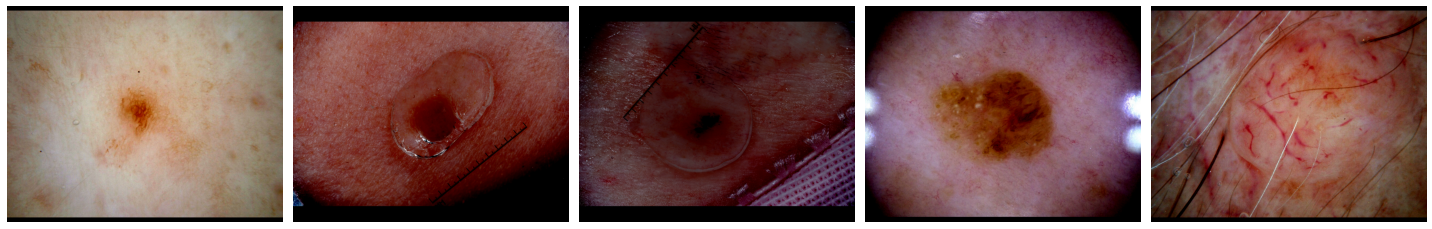

In [19]:
plotImages(sample_training_images[:5])


In [20]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(None, None ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    GlobalMaxPooling2D(),
    Dense(512, activation='relu'),
    Dense(3)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, None, None, 16)    448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    18496     
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

In [23]:
history = model.fit(
    train_dataset,
    steps_per_epoch=62,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=5
)

Epoch 1/15
62/62 [==============================] - 558s 9s/step - loss: 0.8717 - sparse_categorical_accuracy: 0.6739 - val_loss: 1.0345 - val_sparse_categorical_accuracy: 0.5200
Epoch 2/15
62/62 [==============================] - 554s 9s/step - loss: 0.8259 - sparse_categorical_accuracy: 0.6880 - val_loss: 1.0396 - val_sparse_categorical_accuracy: 0.5200
Epoch 3/15
62/62 [==============================] - 555s 9s/step - loss: 0.7955 - sparse_categorical_accuracy: 0.6834 - val_loss: 1.0470 - val_sparse_categorical_accuracy: 0.5067
Epoch 4/15
62/62 [==============================] - 542s 9s/step - loss: 0.7385 - sparse_categorical_accuracy: 0.6992 - val_loss: 0.8090 - val_sparse_categorical_accuracy: 0.6400
Epoch 5/15
62/62 [==============================] - 535s 9s/step - loss: 0.7256 - sparse_categorical_accuracy: 0.6982 - val_loss: 0.8370 - val_sparse_categorical_accuracy: 0.6533
Epoch 6/15
62/62 [==============================] - 540s 9s/step - loss: 0.7104 - sparse_categorical_accu

In [24]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training[1:])
    ax.plot(validation[1:])
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

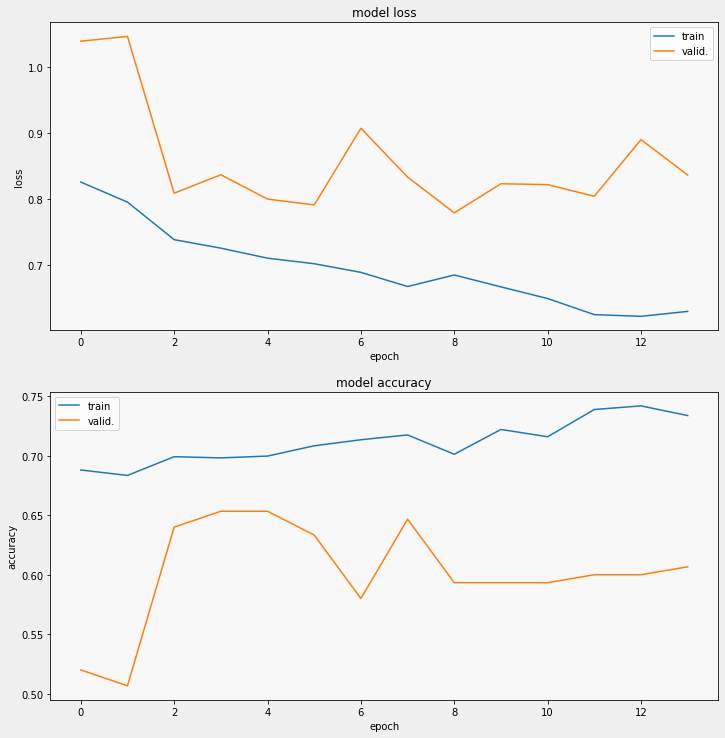

In [27]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)